# Background signal analysis
## Alex Pascual

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from scipy.optimize import curve_fit
from scipy.stats import norm
from statistics import NormalDist
import plotly.express as px
from scipy.stats import gaussian_kde

#machine learning packages
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error

In [49]:
# read the data
data = np.loadtxt('DataSet/dataset.txt', unpack=True, skiprows=2).transpose()

# Read the montecarlo samples
MCb = np.loadtxt('DataSet/mc_bkg.txt', unpack=True, skiprows=2)
MCs = np.loadtxt('DataSet/mc_signal.txt', unpack=True, skiprows=2)

# define the length of the data
l = len(MCs.transpose())

# first half training
MCs_train = MCs.transpose()[0:l//2]
MCb_train = MCb.transpose()[0:l//2]

# second half predicting
MCs_predict = MCs.transpose()[l//2:]
MCb_predict = MCb.transpose()[l//2:]

# defining noise or signal output
zeros = np.zeros(int(l/2)).transpose()
ones = np.ones(int(l/2)).transpose()

# joint samples train
train_sample = np.concatenate((MCb_train,MCs_train))
train_output = np.concatenate((ones,zeros))

# joint samples predict
predict_sample = np.concatenate((MCb_predict, MCs_predict))

In [24]:
# define the network
mlp = MLPRegressor(hidden_layer_sizes = (100, 50), max_iter = 1000, random_state = 21)

# train the network
mlp.fit(train_sample, train_output)

MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=1000, random_state=21)

In [25]:
# predict
predict_output = mlp.predict(predict_sample)

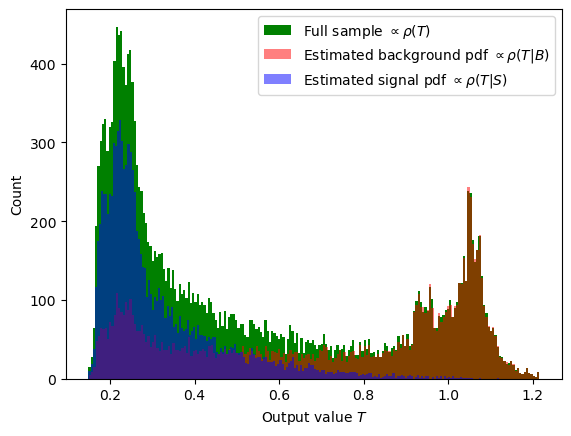

In [35]:
# plot the pdfs
nbins = 200
ay = plt.hist(predict_output, bins = nbins, color = 'green', label = r'Full sample $\propto\rho(T)$')[0]

Back = predict_output[:l//2]
Signal = predict_output[l//2:]

by = plt.hist(Back, bins = nbins, color = 'red', alpha=0.5, label = r'Estimated background pdf $\propto\rho(T|B)$')[0]
bx = np.histogram(Back, bins = nbins)[1]

sy = plt.hist(Signal, bins = nbins, color = 'blue', alpha=0.5, label = r'Estimated signal pdf $\propto\rho(T|S)$')[0]
sx = np.histogram(Signal, bins = nbins)[1]

plt.legend(loc='best')
plt.xlabel(r"Output value $T$")
plt.ylabel("Count")
plt.show()
    

Area = 0.0514
Tcut = 0.6301476420590844


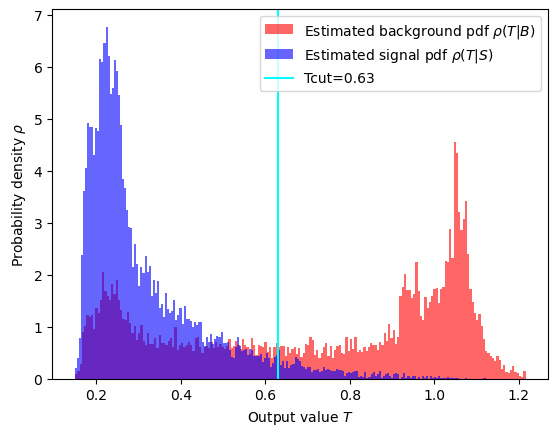

In [43]:
# Find Tcut
# define the pdfs
by = plt.hist(Back, bins = nbins, color = 'red', alpha = 0.6, label = r'Estimated background pdf $\rho(T|B)$', density = True)[0]
bx = np.histogram(Back, bins=nbins)[1]
sy = plt.hist(Signal, bins = nbins,color = 'blue', alpha = 0.6, label = r'Estimated signal pdf $\rho(T|S)$', density = True)[0]
sx = np.histogram(Signal, bins = nbins)[1]

# integrate the background pdf from the upper limit until the area is 0.05
alpha = 0.05
summ = 0
for j in range(len(sy) - 1, 0 - 1, -1):
    summ += sy[j] * (np.max(sx) - np.min(sx)) / nbins
    i = j
    if summ > alpha:
        break
# print the corresponding T_{cut}
print('Area = {}\nTcut = {}'.format(summ, sx[i]))

# plot the T_{cut} line
plt.axvline(sx[i], color = 'cyan', label = 'Tcut={:.2}'.format(sx[i]))
Tcut = sx[i]
plt.legend(loc = 'best')
plt.xlabel(r"Output value $T$")
plt.ylabel(r"Probability density $\rho$")
plt.show()

In [41]:
# calculate power
beta = 0
for j in range(0,i):
    beta += by[j] * (np.max(bx) - np.min(bx)) / nbins
print('Power = {}'.format(1 - beta))

# calculate the areas below Tcut
Sarea = 0
Barea = 0
for i in range(0,100000):
    if sx[i] >= Tcut and by[i] >= Tcut:
        break
    Sarea += sy[i] * (np.max(sx) - np.min(sx)) / nbins
    Barea += by[i] * (np.max(bx) - np.min(bx)) / nbins

print('Signal area = {}\nBackground area = {}'.format(Sarea, Barea))

Power = 0.5743999999999998
Signal area = 0.9542999999999999
Background area = 0.4335000000000002


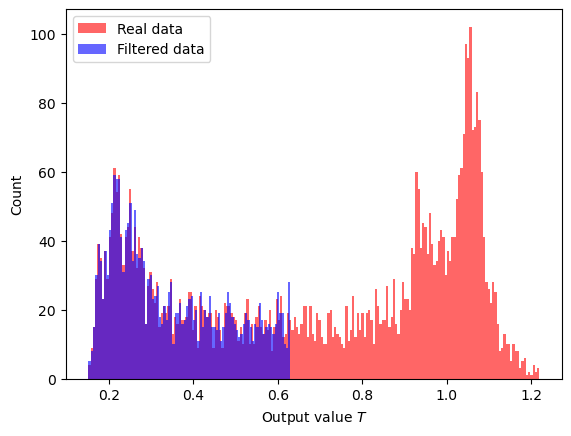

In [46]:
# predict T with the Neural Network
Fdata = mlp.predict(data)
Sdata = Fdata[Fdata < Tcut]

dy = plt.hist(Fdata, bins = nbins, color = 'red', label = 'Real data', alpha = 0.6)[0]
dx = np.histogram(Fdata, bins = nbins)[1]

bins2 = int((np.max(Sdata) - np.min(Sdata)) / ((np.max(Fdata) - np.min(Fdata)) / nbins))
Dy = plt.hist(Sdata, bins = bins2, color = 'blue', label = 'Filtered data', alpha = 0.6)[0]
Dx = np.histogram(Sdata, bins = nbins)[1]

plt.xlabel(r'Output value $T$')
plt.ylabel(r'Count')
plt.legend()
plt.show()

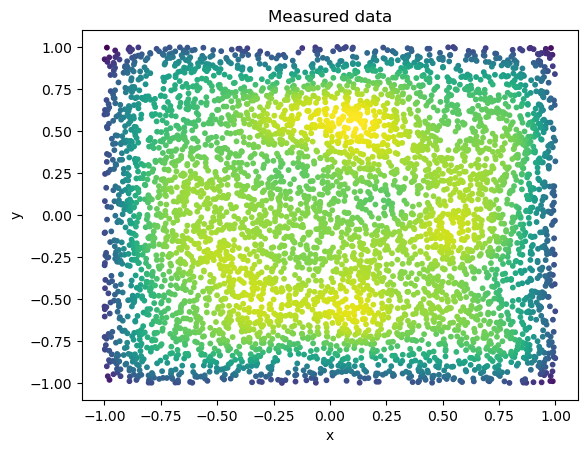

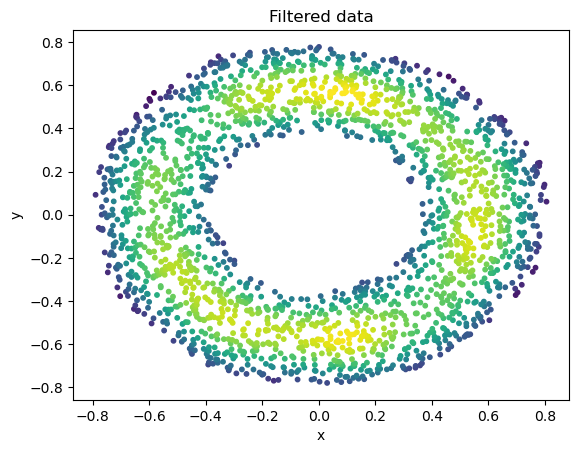

In [47]:
realx=data.transpose()[0]
realy=data.transpose()[1]
xy = np.vstack([realx,realy])

# sort by color/density
z = gaussian_kde(xy)(xy)
idx = z.argsort()
realx, realy, z = realx[idx], realy[idx], z[idx]
fig, ax = plt.subplots()
Real=ax.scatter(realx, realy, c=z, s=10)

# plot
plt.title('Measured data')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

#select the signal without the background
filtx=np.array([])
filty=np.array([])
for i in range(0,int(Fdata.size)):
    if Fdata[i]<Tcut:
        filtx=np.append(filtx,data[i,0])
        filty=np.append(filty,data[i,1])

#calculate density
xy = np.vstack([filtx,filty])

#sort by color/density
z = gaussian_kde(xy)(xy)
idx = z.argsort()
filtx, filty, z = filtx[idx], filty[idx], z[idx]
fig, ax = plt.subplots()
Filtered=ax.scatter(filtx, filty, c=z, s=10)

# plot
plt.title('Filtered data')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

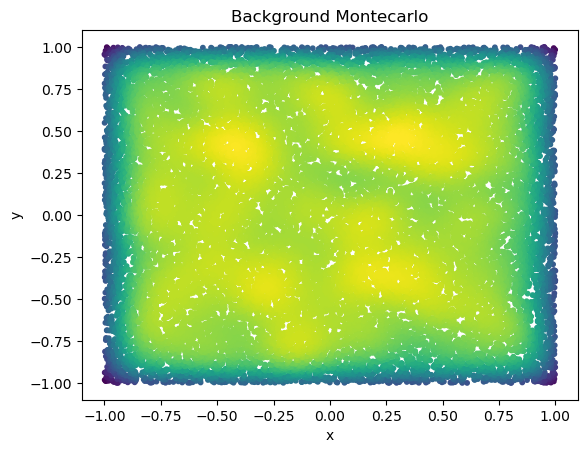

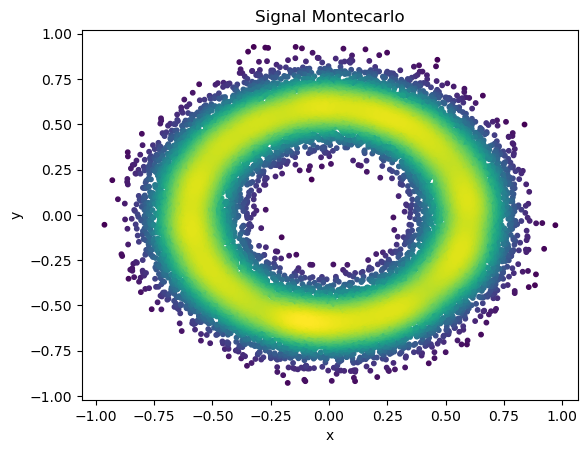

In [48]:
# background montecarlo
Backgroundx = MCb[0]
Backgroundy = MCb[1]
xy = np.vstack([Backgroundx,Backgroundy])

# sort by color/density
z = gaussian_kde(xy)(xy)
idx = z.argsort()
Backgroundx, Backgroundy, z = Backgroundx[idx], Backgroundy[idx], z[idx]
fig, ax = plt.subplots()
Real = ax.scatter(Backgroundx, Backgroundy, c = z, s = 10)

# plot
plt.title('Background Montecarlo')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

# signal montecarlo
Signalx = MCs[0]
Signaly = MCs[1]
xy = np.vstack([Signalx,Signaly])

# sort by color/density
z = gaussian_kde(xy)(xy)
idx = z.argsort()
Signalx, Signaly, z = Signalx[idx], Signaly[idx], z[idx]
fig, ax = plt.subplots()
Filtered = ax.scatter(Signalx, Signaly, c = z, s = 10)

# plot
plt.title('Signal Montecarlo')
plt.xlabel('x')
plt.ylabel('y')
plt.show()